## Mansoor Nabawi, #309498
### Ex04

## KDD

In [108]:
%%writefile kdd_.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics as mt
import glob
import gc


#Initializing MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

##-------------Function Definition--------

#reading dataset
def load_data_kdd(data = "kdd_final_filtered.csv"):
    #freeing up the memory 
    gc.collect()
    #reading the saved dataset
    kdd = pd.read_csv(data, low_memory=False)
    #target
    y = kdd["TARGET_D"].to_numpy()
    x = kdd.drop(columns=["TARGET_D"], axis=1)
 
    bias = pd.DataFrame(np.ones(x.shape[0]).reshape(-1,1), columns = ["bias"])
    x = pd.concat([bias, x], axis=1).to_numpy()
    
    return x, y

#splitting dataset
def train_test_split(data ,frac=0.7):
    data = pd.DataFrame(data)
    #train_test split
    train = data.sample(frac=frac, random_state=10)
    test = data.drop(train.index)
    
    return train.to_numpy(), test.to_numpy()

#normalzining based on rows
def row_normalizer(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

#prediciton
def predict(x, betas):
    return np.matmul(x, betas.T)

#SGD function
def sgd(x, weight, y, y_hat, lr):
    
    #Computing Derivatives using Chain Rule
    dv_loss = x * (-2*(y - y_hat) )
    #Computing new weights    
    weight = weight - lr * dv_loss
    return weight

#calculate_RMSE
def calculate_RMSE(true_y, pred_y):
    return np.sqrt(mt.mean_squared_error(true_y, pred_y))


##----------End of function definition---------

#Master node
if rank == 0:
    print('Loading data...', flush=True)
    x,y = load_data_kdd()
    print(f"X shape: {x.shape}")
    #print("Normalizing")

    x = row_normalizer(x)
    
    print('Splitting into train and test sets...', flush=True)
    x_train, x_test = train_test_split(x ,frac=0.7)
    y_train, y_test = train_test_split(y ,frac=0.7)

    data = np.concatenate((y_train.reshape(-1,1), x_train), axis=1)

    
#fixing seed
np.random.seed(2021)
#random weights
w = np.random.randint(0,5,size=((1,261)))

#learning rate
lr = 0.00001

#Setting the number of epochs
N = 100
train_loss = [] 
test_loss = [] 

converged = False #For checking convergence 
epoch = 0

if rank == 0:
    #Starting time
    t0 = MPI.Wtime()
        
#Training for N Epochs
while (not converged) and (epoch < N):
            
    if rank == 0:
        #print onlt every 10 steps
        if epoch%10==0:
            print("Epoch : ", epoch, flush=True)

        #splitting      
        data_part = np.array_split(data,size)
    else:
        data_part = None
    #Sending data using scatter and weights via bcast
    recvd_dt = comm.scatter(data_part,root=0)
    weights = comm.bcast(w,root=0)
    row_, col_ = np.shape(recvd_dt)
    y_hat = np.zeros((row_,1))
    
    #Shuffling the received dataset at each worker
    np.take(recvd_dt,np.random.permutation(recvd_dt.shape[0]),axis=0,out=recvd_dt)
    #Epoch
    for i in range(0, row_):
        X_part = recvd_dt[i,1:]
        y_part = recvd_dt[i,0]    
        #Prediction of instance i, forward pass
        y_hat[i,0] = predict(X_part, weights.T)

        #Computing new weights    
        weights = sgd(X_part, weights, y_part, y_hat[i,0], lr)
    
    #Gathering weights at Worker 0
    w_r = comm.gather(weights, root=0)
    #Gathering predicted output (yy) and original data (true_dt) at Worker 0
    y_hat_recvd = comm.gather(y_hat, root=0)
    true_dt = comm.gather(recvd_dt[:,0], root=0)

    if rank == 0 and converged == False:
        #Worker 0 computing mean of the weights
        w = np.mean(w_r, axis=0)
        
        pred_y = np.vstack(y_hat_recvd)
        true_y = np.hstack(true_dt)

        #Worker 0 computing calculate_RMSE
        calculate_RMSE_train = calculate_RMSE(true_y, pred_y)
        train_loss.append(calculate_RMSE_train)
    
        #test prediction
        pred_y_test = predict(x_test, w.T)
        #Computing RME Testing
        calculate_RMSE_test = calculate_RMSE(y_test, pred_y_test)
        test_loss.append(calculate_RMSE_test)    

        #Checking for convergence in RMSE test
        if epoch > 0 and abs((test_loss[epoch-1] - test_loss[epoch])) < 10**-6:
            print(test_loss[epoch-1]- test_loss[epoch], flush=True)
            converged = True
    #the converged flag is sent back for stopping epochs
    converged = comm.bcast(converged,root=0)
    epoch += 1

if rank == 0:
    #End time
    t1 = MPI.Wtime()
    df = pd.DataFrame(list(zip(train_loss, test_loss)),columns =['train_loss', 'test_loss'])
    df.to_csv(f"loss{size}.csv", index=False)
    #t1 = MPI.Wtime()
    time_final = t1 - t0
    print("With P = {} Workers, the process took {} seconds" .format(size, time_final), flush=True)


Overwriting kdd_.py


In [386]:
!mpiexec -n 1 python kdd_.py

Loading data...
X shape: (191779, 261)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
2.519192028316297e-07
With P = 1 Workers, the process took 81.56060194969177 seconds


In [387]:
!mpiexec -n 2 python kdd_.py

Loading data...
X shape: (191779, 261)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
8.017752826106062e-07
With P = 2 Workers, the process took 68.61729502677917 seconds


In [388]:
!mpiexec -n 3 python kdd_.py

Loading data...
X shape: (191779, 261)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
-8.628742076410845e-08
With P = 3 Workers, the process took 123.39591813087463 seconds


In [389]:
!mpiexec -n 4 python kdd_.py

Loading data...
X shape: (191779, 261)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
8.224559673308818e-07
With P = 4 Workers, the process took 151.98805499076843 seconds


In [390]:
!mpiexec -n 6 python kdd_.py

Loading data...
X shape: (191779, 261)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
8.61585865763459e-07
With P = 6 Workers, the process took 416.30516505241394 seconds


In [391]:
!mpiexec -n 7 python kdd_.py

Loading data...
X shape: (191779, 261)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 7 Workers, the process took 497.74071192741394 seconds


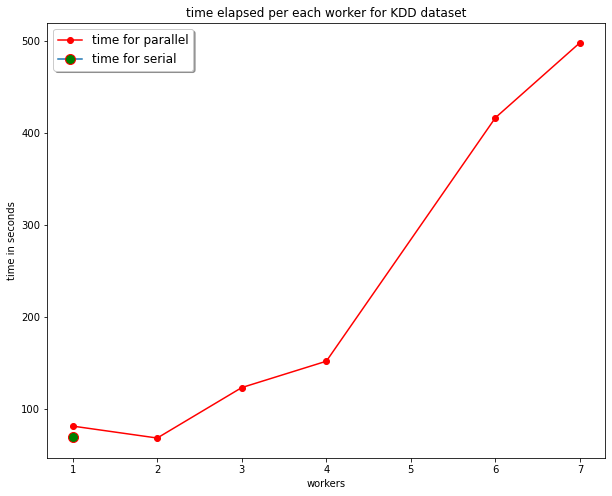

In [74]:
worker = [1,2,3,4,6,7,]
time = [81.560, 68.617, 123.395, 151.988, 416.305, 497.740]
time_ = pd.DataFrame(list(zip(worker, time)),columns =['workers', 'time'])

plt.figure(figsize=(10,8))
plt.plot(time_.workers, time_.time,'ro-', label = "time for parallel")
plt.plot([1],[69.2228], markersize=10, markeredgecolor="red",marker="o", markerfacecolor="green", label = "time for serial" )
plt.title('time elapsed per each worker for KDD dataset')
plt.xlabel('workers')
plt.ylabel('time in seconds')
plt.legend(shadow=True, fontsize='large')
plt.savefig("speed_curves.png")
plt.show()    

with 1 worker Training RMSE =  4.613436450887918
with 2 worker Training RMSE =  4.613523567138851
with 3 worker Training RMSE =  4.61347371917799
with 4 worker Training RMSE =  4.613503185598911
with 5 worker Training RMSE =  4.613496871857076
with 6 worker Training RMSE =  4.613526570315336


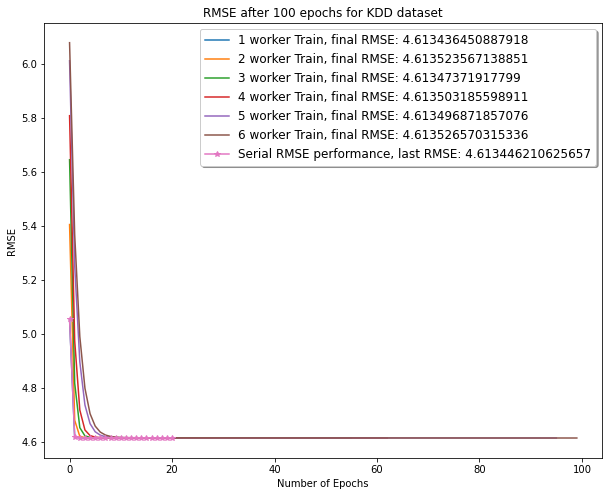

In [24]:
loss1 = pd.read_csv("loss1.csv", sep=",")
loss2 = pd.read_csv("loss2.csv", sep=",")
loss3 = pd.read_csv("loss3.csv", sep=",")
loss4 = pd.read_csv("loss4.csv", sep=",")
loss6 = pd.read_csv("loss6.csv", sep=",")
loss7 = pd.read_csv("loss7.csv", sep=",")
losses_kdd = [loss1, loss2, loss3, loss4, loss6, loss7]

plt.figure(figsize=(10,8))
counter = 1
for loss in losses_kdd:
    
    print(f"with {counter} worker Training RMSE = ", loss.train_loss.iloc[-1], flush=True)

    plt.plot(loss.train_loss,  label=f'{counter} worker Train, final RMSE: {loss.train_loss.iloc[-1]}') 
    counter += 1
#serial performance
plt.plot(train_loss_kdd,  label=f'Serial RMSE performance, last RMSE: {train_loss_kdd[-1]}', marker='*') 
plt.title('RMSE after 100 epochs for KDD dataset')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper right', shadow=True, fontsize='large')
plt.savefig("train_curves.png")
plt.show()        


with 1 worker Testing RMSE =  4.507883904780432
with 2 worker Testing RMSE =  4.5079240849230855
with 3 worker Testing RMSE =  4.507896153147608
with 4 worker Testing RMSE =  4.507910987528902
with 5 worker Testing RMSE =  4.507908547959393
with 6 worker Testing RMSE =  4.507922556541326


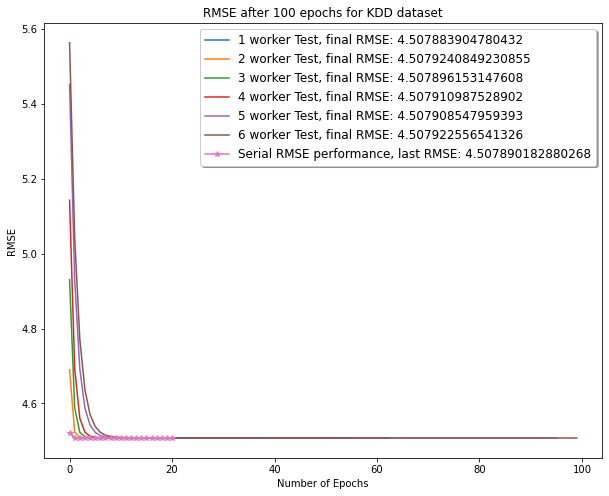

In [25]:
plt.figure(figsize=(10,8))
counter = 1
for loss in losses_kdd:
    print(f"with {counter} worker Testing RMSE = ", loss.test_loss.iloc[-1], flush=True)
    plt.plot(loss.test_loss,  label=f'{counter} worker Test, final RMSE: {loss.test_loss.iloc[-1]}') 
    #plt.plot(loss.test_loss.iloc[-1],marker='o')
    counter += 1
#serial performance
plt.plot(test_loss_kdd,  label=f'Serial RMSE performance, last RMSE: {test_loss_kdd[-1]}', marker='*') 
plt.title('RMSE after 100 epochs for KDD dataset')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper right', shadow=True, fontsize='large')
plt.savefig("test_curves.png")
plt.show()    

In [13]:
%%writefile kdd_serial.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics as mt
import glob
import time
import gc



def load_data_kdd(data = "kdd_final_filtered.csv"):
    #freeing up the memory 
    gc.collect()
    #reading the saved dataset
    kdd = pd.read_csv(data, low_memory=False)
    #target
    y = kdd["TARGET_D"].to_numpy()
    x = kdd.drop(columns=["TARGET_D"], axis=1)
 
    bias = pd.DataFrame(np.ones(x.shape[0]).reshape(-1,1), columns = ["bias"])
    x = pd.concat([bias, x], axis=1).to_numpy()
    
    return x, y

def train_test_split(data ,frac=0.7):
    data = pd.DataFrame(data)
    #train_test split
    train = data.sample(frac=frac, random_state=10)
    test = data.drop(train.index)
    
    return train.to_numpy(), test.to_numpy()

def normalize_rows(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

print('Loading data...', flush=True)
x,y = load_data_kdd()
print(f"X shape: {x.shape}")
x = normalize_rows(x)
print('Splitting into train and test sets...', flush=True)
x_train, x_test = train_test_split(x ,frac=0.7)
y_train, y_test = train_test_split(y ,frac=0.7)

data = np.concatenate((y_train, x_train), axis=1)
#Initializing weights = 0
# w = np.zeros((1,480), dtype=float)
np.random.seed(2021)
weights = np.random.randint(0,5,size=((1,261)))

#learning rate
lr = 0.00001

#Setting the number of epochs
N = 100
train_loss_kdd = [] 
test_loss_kdd = [] 

converged = False #For checking convergence 
j = 0


t0 = MPI.Wtime()
arrow = y_train.shape[0]

#Training for N Epochs
while (not converged) and (j < N):
    if j%10==0:
        print("Epoch : ", j, flush=True)

    yy = np.zeros((arrow,1))
    closs = 0
    #Shuffling the received dataset at each worker
    np.take(data,np.random.permutation(data.shape[0]),axis=0,out=data)
    #Epoch
    for i in range(0, arrow):
        xt = data[i,1:]
        yt = data[i,0]    
        #Forward pass
        yy[i,0] = np.matmul(xt, weights.T)
        #Backpropagation
        #Computing Derivatives
        derv_lossyy = -2*(yt - yy[i,0])
        derv_yyw = xt
        #Computing Derivatives using Chain Rule
        derv_lossw = derv_lossyy * derv_yyw 

        #Computing new weights    
        weights = weights - lr * derv_lossw
    

    tloss = np.sqrt(mt.mean_squared_error(data[:,0], yy[:,0]))
    train_loss_kdd.append(tloss)

    #Evaluating the model
    z = np.matmul(x_test, weights.T)
    #Computing RME Testing
    vloss = np.sqrt(mt.mean_squared_error(y_test, z))
    test_loss_kdd.append(vloss)    

    #Checking for convergence if the change in RMSE testing is less than 10^-6
    if j > 0 and abs((test_loss_kdd[j-1] - test_loss_kdd[j])) < 10**-6:
        print(test_loss_kdd[j-1]- test_loss_kdd[j], flush=True)
        converged = True

    j += 1
    
print("No of iterations = ", j, flush=True)
print("Training RMSE = ", train_loss_kdd[j-1], flush=True)
print("Min Training RMSE = ", np.min(train_loss_kdd), flush=True)
print("Testing RMSE = ", test_loss_kdd[j-1], flush=True)
print("Min Testing RMSE = ", np.min(test_loss_kdd), flush=True)
#Ending time    
time_end = MPI.Wtime()
time_taken = time_end - t0
print("Time elapsed for serial code:", time_taken)

Overwriting kdd_serial.py


In [14]:
time_taken

69.22283792495728

In [7]:
test_loss_kdd

[4.521449159732766,
 4.508618710346539,
 4.5084476223542715,
 4.508357809945919,
 4.508239069002416,
 4.508160705451755,
 4.508101833792286,
 4.5080765680952615,
 4.508035270440869,
 4.507992548027765,
 4.507975408022605,
 4.507953679946805,
 4.507939217769814,
 4.507927347979276,
 4.50791593907453,
 4.507908812676375,
 4.507902340199169,
 4.507898185290271,
 4.5079244109812695,
 4.507889981414736,
 4.507890182880268]

In [8]:
train_loss_kdd

[5.054174692634139,
 4.616884365559186,
 4.614371527100599,
 4.614178594461629,
 4.614072919277264,
 4.613959084775939,
 4.613864043437512,
 4.6137780951949106,
 4.6137314411796835,
 4.613682142691939,
 4.613640831255039,
 4.613567619797087,
 4.613559888835824,
 4.6135527649329635,
 4.613535778848796,
 4.613512598273482,
 4.613497195114172,
 4.613479107124148,
 4.61345333445909,
 4.613459158855416,
 4.613446210625657]

In [76]:
time_["speedup"] = (69.222)/time_.time
time_["efficiency"] = time_["speedup"]/time_.workers

In [109]:
time_

workers      time   speedup  efficiency
0        1  1.359333  0.848725    0.848725
1        2  1.143617  1.008817    0.504409
2        3  2.056583  0.560979    0.186993
3        4  2.533133  0.455444    0.113861
4        6  6.938417  0.166277    0.027713
5        7  8.295667  0.139073    0.019868

In [83]:
time_["time"]=time_.time/60

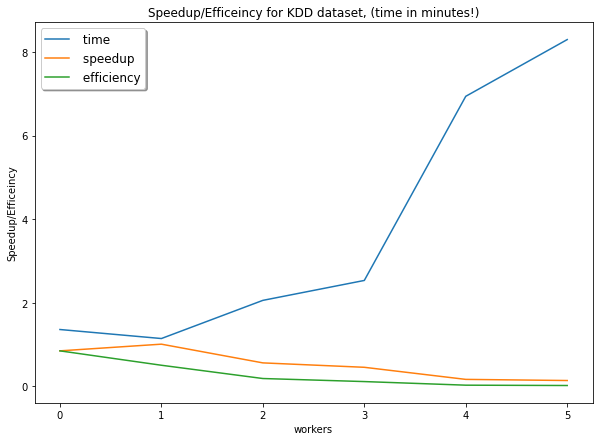

In [89]:
counter = 1
plt.figure(figsize=(10,7))
for col in ['time', 'speedup', 'efficiency']:
    plt.plot(time_[col], label = f" {col}")
    #plt.plot(ltime[col], label = f"speedup_train with {counter} workers")
    counter += 1
plt.title("Speedup/Efficeincy for KDD dataset, (time in minutes!)")
plt.ylabel("Speedup/Efficeincy")
plt.xlabel("workers")
plt.legend(shadow=True, fontsize='large')
plt.savefig("Speedup_Efficeincy_kdd.png")
plt.show()


In [117]:
%%writefile virus.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics as mt
import glob
import gc
import os

#Initializing MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

##-----Function Definition-----

def load_virus():
    #freeing up the memory 
    gc.collect()
    path = 'dataset/dataset/'
    files = os.listdir(path)
    li = []
    for filename in files:
        df = pd.read_csv(path+filename, header=None)
        li.append(df)

    dat_file = pd.concat(li, axis=0, ignore_index=True)

    y = np.zeros((107856,1), float)
    x = np.zeros((107856,479))
    for i in dat_file.index:
        doc = dat_file.iloc[i][0].strip().split()
        y[i] = float(doc[0])

        for element in doc[1:]:
            k, v = element.split(":")
            x[i,int(k)] = int(v)
    bias = np.ones((107856,1))
    x = np.append(bias, x, axis=1)
            
    return x,y 

#splitting dataset
def train_test_split(data ,frac=0.7):
    data = pd.DataFrame(data)
    #train_test split
    train = data.sample(frac=frac, random_state=10)
    test = data.drop(train.index)
    
    return train.to_numpy(), test.to_numpy()

#normalzining based on rows
def row_normalizer(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

#prediciton
def predict(x, betas):
    return np.matmul(x, betas.T)

#SGD function
def sgd(x, weight, y, y_hat, lr):
    
    #Computing Derivatives using Chain Rule
    dv_loss = x * (-2*(y - y_hat) )
    #Computing new weights    
    weight = weight - lr * dv_loss
    return weight

#calculate_RMSE
def calculate_RMSE(true_y, pred_y):
    return np.sqrt(mt.mean_squared_error(true_y, pred_y))

##-------End of Definition---------


if rank == 0:
    print('Loading data...', flush=True)
    x,y = load_virus()
    print(f"X shape: {x.shape}")
    x = normalize_rows(x)
    print('Splitting into train and test sets...', flush=True)
    x_train, x_test = train_test_split(x ,frac=0.7)
    y_train, y_test = train_test_split(y ,frac=0.7)

    data = np.concatenate((y_train.reshape(-1,1), x_train), axis=1)

    
#Initializing weights

w = np.random.randint(0,2,size=((1,480)))

#learning rate
lr = 0.00001

#Setting the number of epochs
N = 100
train_loss = [] 
test_loss = [] 

converged = False #For checking convergence 
epoch = 0

if rank == 0:
    #Starting time
    t0 = MPI.Wtime()
        
#Training for N Epochs
while (not converged) and (epoch < N):
            
    if rank == 0:
        #print onlt every 10 steps
        if epoch%10==0:
            print("Epoch : ", epoch, flush=True)

        #splitting      
        data_part = np.array_split(data,size)
    else:
        data_part = None
    #Sending data using scatter and weights via bcast
    recvd_dt = comm.scatter(data_part,root=0)
    weights = comm.bcast(w,root=0)
    row_, col_ = np.shape(recvd_dt)
    y_hat = np.zeros((row_,1))
    
    #Shuffling the received dataset at each worker
    np.take(recvd_dt,np.random.permutation(recvd_dt.shape[0]),axis=0,out=recvd_dt)
    #Epoch
    for i in range(0, row_):
        X_part = recvd_dt[i,1:]
        y_part = recvd_dt[i,0]    
        #Prediction of instance i, forward pass
        y_hat[i,0] = predict(X_part, weights.T)

        #Computing new weights    
        weights = sgd(X_part, weights, y_part, y_hat[i,0], lr)
    
    #Gathering weights at Worker 0
    w_r = comm.gather(weights, root=0)
    #Gathering predicted output (yy) and original data (true_dt) at Worker 0
    y_hat_recvd = comm.gather(y_hat, root=0)
    true_dt = comm.gather(recvd_dt[:,0], root=0)

    if rank == 0 and converged == False:
        #Worker 0 computing mean of the weights
        w = np.mean(w_r, axis=0)
        
        pred_y = np.vstack(y_hat_recvd)
        true_y = np.hstack(true_dt)

        #Worker 0 computing calculate_RMSE
        calculate_RMSE_train = calculate_RMSE(true_y, pred_y)
        train_loss.append(calculate_RMSE_train)
    
        #test prediction
        pred_y_test = predict(x_test, w.T)
        #Computing RME Testing
        calculate_RMSE_test = calculate_RMSE(y_test, pred_y_test)
        test_loss.append(calculate_RMSE_test)    

        #Checking for convergence in RMSE test
        if epoch > 0 and abs((test_loss[epoch-1] - test_loss[epoch])) < 10**-6:
            print(test_loss[epoch-1]- test_loss[epoch], flush=True)
            converged = True
    #the converged flag is sent back for stopping epochs
    converged = comm.bcast(converged,root=0)
    epoch += 1

if rank == 0:
    #Ending time
    t1 = MPI.Wtime()
    df = pd.DataFrame(list(zip(train_loss, test_loss)),columns =['train_loss', 'test_loss'])
    df.to_csv(f"loss_virus{size}.csv", index=False)
    #t1 = MPI.Wtime()
    time_final = t1 - t0
    print("With P = {} Workers, the process took {} seconds" .format(size, time_final), flush=True)

Overwriting virus.py


In [337]:
!mpirun -n 4 python virus.py

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 4 Workers, the process took 130.96906805038452 seconds


In [338]:
!mpirun -n 1 python virus.py

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 1 Workers, the process took 233.23658204078674 seconds


In [339]:
!mpirun -n 2 python virus.py

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 2 Workers, the process took 144.2443768978119 seconds


In [340]:
!mpirun -n 6 python virus.py

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 6 Workers, the process took 236.01111006736755 seconds


In [341]:
!mpirun -n 7 python virus.py

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 7 Workers, the process took 326.97588205337524 seconds


In [342]:
!mpirun -n 3 python virus.py

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
With P = 3 Workers, the process took 135.1302969455719 seconds


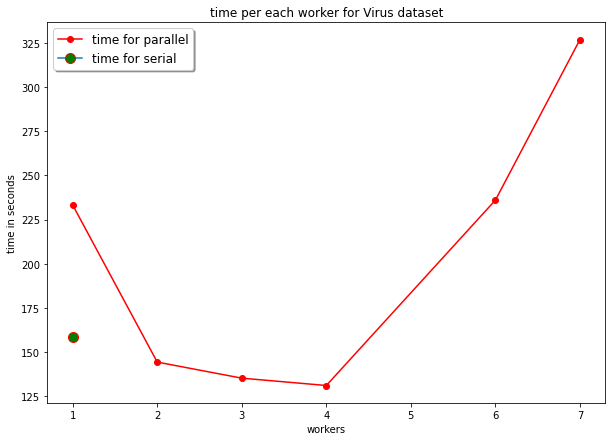

In [116]:
import matplotlib.pyplot as plt

worker = [1,2,3,4,6,7,]
time = [233.23, 144.24 , 135.13, 130.969, 236.011, 326.97]
time_virus = pd.DataFrame(list(zip(worker, time)),columns =['workers', 'time'])

plt.figure(figsize=(10,7))
plt.plot(time_virus.workers, time_virus.time,'ro-', label = "time for parallel")
plt.plot([1],[158.287], markersize=10, markeredgecolor="red",marker="o", markerfacecolor="green", label = "time for serial" )
plt.title('time per each worker for Virus dataset')
plt.xlabel('workers')
plt.ylabel('time in seconds')
plt.legend(shadow=True, fontsize='large')
plt.savefig("speed_curves_virus.png")
plt.show()   

In [94]:
time_virus

workers     time
0        1  233.230
1        2  144.240
2        3  135.130
3        4  130.969
4        6  236.011
5        7  326.970

with 1 worker Training RMSE =  0.2868272477024327
with 2 worker Training RMSE =  0.313140648408823
with 3 worker Training RMSE =  0.316935901206471
with 4 worker Training RMSE =  0.3361796599192343
with 5 worker Training RMSE =  0.3942124162833801
with 6 worker Training RMSE =  0.3444787957716085


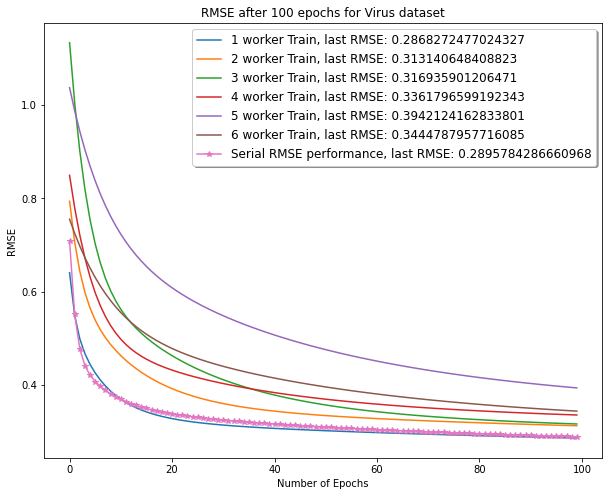

In [450]:
loss1 = pd.read_csv("loss_virus1.csv", sep=",")
loss2 = pd.read_csv("loss_virus2.csv", sep=",")
loss3 = pd.read_csv("loss_virus3.csv", sep=",")
loss4 = pd.read_csv("loss_virus4.csv", sep=",")
loss6 = pd.read_csv("loss_virus6.csv", sep=",")
loss7 = pd.read_csv("loss_virus7.csv", sep=",")

losses = [loss1, loss2, loss3, loss4, loss6, loss7]

plt.figure(figsize=(10,8))
counter = 1
for loss in losses:
    
    print(f"with {counter} worker Training RMSE = ", loss.train_loss.iloc[-1], flush=True)

    plt.plot(loss.train_loss,  label=f'{counter} worker Train, last RMSE: {loss.train_loss.iloc[-1]}') 
    counter += 1
#serial performance
plt.plot(train_loss,  label=f'Serial RMSE performance, last RMSE: {train_loss[-1]}', marker='*') 

plt.title('RMSE after 100 epochs for Virus dataset')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper right', shadow=True, fontsize='large')
plt.savefig("train_curves_virus.png")
plt.show()        


with 1 worker Testing RMSE =  0.2846947463927944
with 2 worker Testing RMSE =  0.3109302120556372
with 3 worker Testing RMSE =  0.3160206663693448
with 4 worker Testing RMSE =  0.3321859119360509
with 5 worker Testing RMSE =  0.3914890128888181
with 6 worker Testing RMSE =  0.3435406911877392


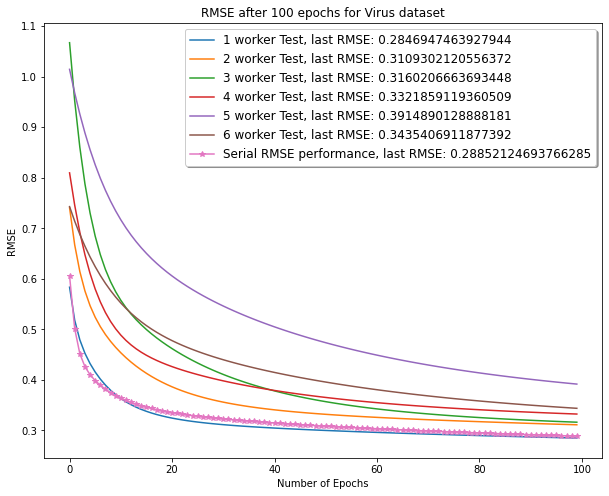

In [451]:
plt.figure(figsize=(10,8))
counter = 1
for loss in losses:
    
    print(f"with {counter} worker Testing RMSE = ", loss.test_loss.iloc[-1], flush=True)

    plt.plot(loss.test_loss,  label=f'{counter} worker Test, last RMSE: {loss.test_loss.iloc[-1]}') 
    counter += 1
#serial performance
plt.plot(test_loss,  label=f'Serial RMSE performance, last RMSE: {test_loss[-1]}', marker='*') 
plt.title('RMSE after 100 epochs for Virus dataset')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper right', shadow=True, fontsize='large')
plt.savefig("test_curves_virus.png")
plt.show()        


with 1 worker Testing RMSE =  0.2846947463927944
with 2 worker Testing RMSE =  0.3109302120556372
with 3 worker Testing RMSE =  0.3160206663693448
with 4 worker Testing RMSE =  0.3321859119360509
with 5 worker Testing RMSE =  0.3914890128888181
with 6 worker Testing RMSE =  0.3435406911877392


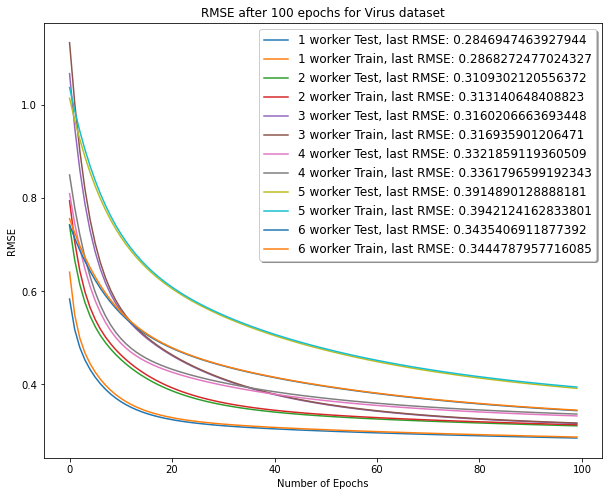

In [418]:
plt.figure(figsize=(10,8))
counter = 1
for loss in losses:
    
    print(f"with {counter} worker Testing RMSE = ", loss.test_loss.iloc[-1], flush=True)

    plt.plot(loss.test_loss,  label=f'{counter} worker Test, last RMSE: {loss.test_loss.iloc[-1]}') 
    plt.plot(loss.train_loss,  label=f'{counter} worker Train, last RMSE: {loss.train_loss.iloc[-1]}') 
    counter += 1

plt.title('RMSE after 100 epochs for Virus dataset')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend(loc='upper right', shadow=True, fontsize='large')
#plt.savefig("test_curves_virus.png")
plt.show()        


In [443]:
%%writefile virus_serial.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics as mt
import glob
import time



def load_virus():
    #freeing up the memory 
    gc.collect()
    path = 'dataset/dataset/'
    files = os.listdir(path)
    li = []
    for filename in files:
        df = pd.read_csv(path+filename, header=None)
        li.append(df)

    dat_file = pd.concat(li, axis=0, ignore_index=True)

    y = np.zeros((107856,1), float)
    x = np.zeros((107856,479))
    for i in dat_file.index:
        doc = dat_file.iloc[i][0].strip().split()
        y[i] = float(doc[0])

        for element in doc[1:]:
            k, v = element.split(":")
            x[i,int(k)] = int(v)
    bias = np.ones((107856,1))
    x = np.append(bias, x, axis=1)
            
    return x,y 

def train_test_split(data ,frac=0.7):
    data = pd.DataFrame(data)
    #train_test split
    train = data.sample(frac=frac, random_state=10)
    test = data.drop(train.index)
    
    return train.to_numpy(), test.to_numpy()

def normalize_rows(x: np.ndarray):
    return x/np.linalg.norm(x, ord=2, axis=1, keepdims=True)

print('Loading data...', flush=True)
x,y = load_virus()
print(f"X shape: {x.shape}")
x = normalize_rows(x)
print('Splitting into train and test sets...', flush=True)
x_train, x_test = train_test_split(x ,frac=0.7)
y_train, y_test = train_test_split(y ,frac=0.7)

data = np.concatenate((y_train, x_train), axis=1)

weights = np.random.randint(0,2,size=((1,480)))

#learning rate
lr = 0.00001

#Setting the number of epochs
N = 100
train_loss = [] 
test_loss = [] 

converged = False #For checking convergence 
j = 0


t0 = MPI.Wtime()
arrow = y_train.shape[0]

#Training for N Epochs
while (not converged) and (j < N):
    if j%10==0:
        print("Epoch : ", j, flush=True)

    yy = np.zeros((arrow,1))
    closs = 0
    #Shuffling the received dataset at each worker
    np.take(data,np.random.permutation(data.shape[0]),axis=0,out=data)
    #Epoch
    for i in range(0, arrow):
        xt = data[i,1:]
        yt = data[i,0]    
        #forward pass
        yy[i,0] = np.matmul(xt, weights.T)
        #Backpropagation
        #Computing Derivatives
        derivative_loss = -2*(yt - yy[i,0])
        derv_yyw = xt
        #Computing Derivatives using Chain Rule
        drv_2_sgd = derivative_loss * derv_yyw 

        #Computing new weights    
        weights = weights - lr * drv_2_sgd
    

    tloss = np.sqrt(mt.mean_squared_error(data[:,0], yy[:,0]))
    train_loss.append(tloss)

    #Evaluating the model
    z = np.matmul(x_test, weights.T)
    #Computing RME Testing
    vloss = np.sqrt(mt.mean_squared_error(y_test, z))
    test_loss.append(vloss)    

    #Checking for convergence if the change in RMSE testing is less than 10^-6
    if j > 0 and abs((test_loss[j-1] - test_loss[j])) < 10**-6:
        print(test_loss[j-1]- test_loss[j], flush=True)
        converged = True

    j += 1
    
print("No of iterations = ", j, flush=True)
print("Training RMSE = ", train_loss[j-1], flush=True)
print("Min Training RMSE = ", np.min(train_loss), flush=True)
print("Testing RMSE = ", test_loss[j-1], flush=True)
print("Min Testing RMSE = ", np.min(test_loss), flush=True)
#Ending time    
time_end = MPI.Wtime()
time_taken = time_end - t0
print("Time elapsed for serial code:", time_taken)

Loading data...
X shape: (107856, 480)
Splitting into train and test sets...
Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
No of iterations =  100
Training RMSE =  0.2895784286660968
Min Training RMSE =  0.2895784286660968
Testing RMSE =  0.28852124693766285
Min Testing RMSE =  0.28852124693766285


In [445]:
print("Time elapsed for serial code:", time_taken)

Time elapsed for serial code: 158.2873260974884


In [446]:
train_loss

[0.7088760461196701,
 0.5514829742228728,
 0.47782227720905907,
 0.44183681702971384,
 0.42154901353737656,
 0.4079278314895835,
 0.3975053367200863,
 0.3889315001461763,
 0.38162325096815247,
 0.37528746862310913,
 0.3697440055338884,
 0.3648642905825689,
 0.36054660082297013,
 0.35670931666717354,
 0.3532839123458854,
 0.35021179153675513,
 0.34744481596247984,
 0.34493960576898663,
 0.34265956882820964,
 0.34057519735371333,
 0.3386604069128099,
 0.33689247968992386,
 0.3352528370865819,
 0.3337254259312653,
 0.33229617174472403,
 0.33095359442525335,
 0.3296875404890787,
 0.328489033753937,
 0.327350065594591,
 0.3262645857386369,
 0.3252271335435897,
 0.3242328984875382,
 0.32327745970493377,
 0.3223577012953791,
 0.3214695700147539,
 0.32061101389626323,
 0.319779284931483,
 0.31897252100097606,
 0.31818850318669584,
 0.3174258778162085,
 0.31668330105434783,
 0.31595900909204244,
 0.3152523579282049,
 0.31456198586889256,
 0.31388699146503246,
 0.3132266068566486,
 0.31258034762

In [447]:
test_loss

[0.6055765400466021,
 0.5011376177775915,
 0.45181763375487527,
 0.42601738124645555,
 0.4100287157917783,
 0.3984227857008285,
 0.38915147217409113,
 0.3813600107961645,
 0.37466389953233753,
 0.3688370107432617,
 0.36373324257788764,
 0.3592375705941146,
 0.3552594495024706,
 0.3517248620035166,
 0.34856789092290763,
 0.34573691116422317,
 0.34318645788625723,
 0.34087535855934914,
 0.3387711014523561,
 0.33684639997679866,
 0.3350753018344959,
 0.333439464501066,
 0.33191998716020976,
 0.33050322514016695,
 0.32917513956688677,
 0.32792601248693914,
 0.32674723247355225,
 0.32562910321668415,
 0.3245653960484065,
 0.323550173056404,
 0.3225781201158182,
 0.32164530094168314,
 0.32074764204265854,
 0.3198822998732191,
 0.3190463764067099,
 0.3182367767568505,
 0.3174510448495658,
 0.31668873014955334,
 0.31594731899049855,
 0.3152243665238744,
 0.31452003689171454,
 0.31383234133653065,
 0.3131609728085975,
 0.31250478815568106,
 0.3118628867635054,
 0.311233687458854,
 0.31061769043

In [101]:
time_virus

workers      time    speedup  efficiency
0        1  0.064786  40.718604    0.848725
1        2  0.040067  65.840266    0.504409
2        3  0.037536  70.278991    0.186993
3        4  0.036380  72.511816    0.113861
4        6  0.065559  40.238802    0.027713
5        7  0.090825  29.044867    0.019868

In [99]:
time_virus["speedup"] = (158.28)/time_virus.time
time_virus["efficiency"] = time_["speedup"]/time_virus.workers

In [100]:
time_virus["time"]=time_virus.time/60

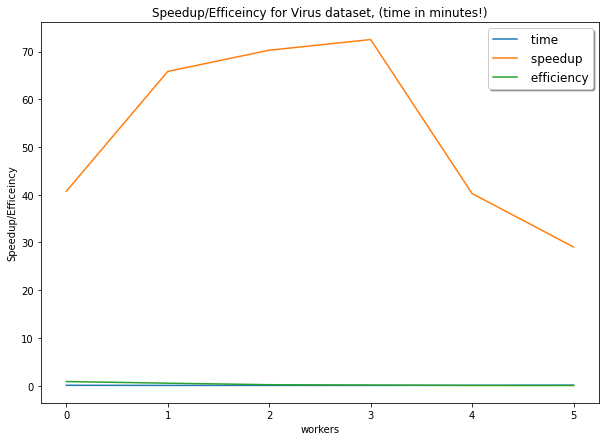

In [110]:
counter = 1
plt.figure(figsize=(10,7))
for col in ["time",'speedup', 'efficiency']:
    plt.plot(time_virus[col], label = f" {col}")
    #plt.plot(ltime[col], label = f"speedup_train with {counter} workers")
    counter += 1
plt.title("Speedup/Efficeincy for Virus dataset, (time in minutes!)")
plt.ylabel("Speedup/Efficeincy")
plt.xlabel("workers")
plt.legend(shadow=True, fontsize='large')
plt.savefig("Speedup_Efficeincy_virus.png")
plt.show()
